# Creating temperature dependent variables with python

This documentation describes the analysis and evaluation of of real mechanical tests of carbon fiber reinfoced plastics (CFRP) with temperature as the main variable.
For computation, python will be used.
While tensile and compressive testing in longitudinal and transverse direction showed a simple linear stress strain behavior, one can observe a nonlinear behavior under shear stress.
Mathematically, this can be solved by using the Ramberg-Osgood (RO) Equation:

\begin{align}
\gamma_{12}=\frac{\tau_{12} + \alpha_{\mathrm{PL}}\tau_{12}^{n_{\mathrm{PL}}} }{G_{12}}
\end{align}

| variable                                             | Meaning        | Unit |
|:----------------------------------------------------:|:--------------:|:----:|
| \begin{equation*}\gamma_{12}\end{equation*}          | shear strain   |  -   |
| \begin{equation*}\tau_{12}\end{equation*}            | shear stress   | MPa  |
| \begin{equation*}G_{12}\end{equation*}               | shear modulus  | MPa  |
| \begin{equation*}\alpha_{\mathrm{PL}}\end{equation*} | RO-parameter 1 | -    |
| \begin{equation*}n_{\mathrm{PL}}\end{equation*}      | RO-parameter 2 | -    |

There are 2 goals within this script:
- compute the RO parameters
- find a formula to calculate the RO parameters with temperature as the main variable

The shear modulus is given by the mechanical testing and will be used.

## Import Libraries

First, we need certain libraries for our script. These will be:
- Numpy
- Pandas
- Scipy or one of its component, respectively
- Matplotlib
- OS
- Glob

In [706]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import os
import glob

For step 1 i.e. computating values for the RO parameters, we will demonstrate what the code does for 20°C only. For that, we store the values into arrays. Each values for stress and strain are stored into txt files. We need their path and open them.

In [707]:
# For simplicity, all files are stored into the same directory like this ipython notebook file.
# These files are called "XX-y.txt, where XX stands for a certain temperature and y the number of testing."
# Furthermore, we need to get access to the files.

txtfiles = glob.glob("*.txt")

In [708]:
txtfiles

['80-4.txt',
 '40-4.txt',
 '60-2.txt',
 '20-2.txt',
 '20-4.txt',
 '40-2.txt',
 '80-3.txt',
 '80-1.txt',
 '80-2.txt',
 '20-1.txt',
 '60-4.txt',
 '100-2.txt',
 '20-3.txt',
 '100-1.txt',
 '100-3.txt',
 '60-1.txt',
 '100-5.txt',
 '40-1.txt',
 '100-4.txt',
 '40-3.txt',
 '60-3.txt',
 '40-5.txt']

We only need to load these files for 20°C. I suppose that the number of xy values might not be equal, so first, let's see how many values are stored in each file. Furthermore, we need a number to know how many files are addressed.
However, we don't know the size of each file. We don't know be default, how many files we have to deal with. Therefore we have to work with dynamic lists and cannot work with numpy arrays only.
In order to know the lengths of each files, we save their lengths into a third array.

In [709]:
strains = []
stresses = []
lengths = []
strains

[]

In [710]:
i=0
for file in txtfiles:
    if file[0:3] == "20-":
        strains.append(np.loadtxt(file, delimiter="\t", usecols=(0)))
        stresses.append(np.loadtxt(file, delimiter="\t", usecols=(1)))
        lengths.append(len(strains[i]))
        i+=1

In [711]:
lengths

[109, 99, 89, 399]

Let's see how the strain values look within a dataframe.

In [712]:
dfstrain = pd.DataFrame(strains)
dfstrain

,0,1,2,3,4,5,6,7,8,9,...,389,390,391,392,393,394,395,396,397,398
0,0.001030,0.001157,0.001183,0.001379,0.001554,0.001745,0.001959,0.002130,0.002275,0.002475,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.000444,0.000693,0.000917,0.000922,0.001236,0.001328,0.001729,0.001910,0.002128,0.002335,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.000552,0.000698,0.000834,0.001029,0.001276,0.001271,0.001534,0.001754,0.001938,0.002117,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.000470,0.000531,0.000594,0.000658,0.000723,0.000786,0.000846,0.000901,0.000951,0.000997,...,0.021945,0.022037,0.02212,0.022193,0.022261,0.022326,0.022391,0.022459,0.022531,0.022604


In [713]:
dfstresses = pd.DataFrame(stresses)
dfstresses

,0,1,2,3,4,5,6,7,8,9,...,389,390,391,392,393,394,395,396,397,398
0,4.298747,5.254041,6.209297,7.177150,8.182717,9.181985,10.193812,11.218198,12.223765,13.223033,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2.399550,3.281911,4.208726,5.205330,6.163878,7.160519,8.188892,9.210904,10.232953,11.261288,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2.442385,3.230868,4.064205,4.968054,5.942454,6.929664,7.923259,8.948937,9.981001,11.013065,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2.215472,2.416858,2.624552,2.844860,3.058861,3.272862,3.505710,3.732288,3.952596,4.179175,...,63.15339,63.15339,63.15339,63.172274,63.191159,63.216313,63.235198,63.26666,63.285545,63.304429


According to the RO equation, there is no offset. Either, we add 0 to index 0 or we compute the offset at index 0 and calibrate all values. We will do the former option.

In [714]:
for i in range(len(lengths)):
    offsetx = strains[i][0]
    offsety = stresses[i][0]
    strains[i]-=offsetx
    stresses[i]-=offsety

In [715]:
dfstrain = pd.DataFrame(strains)
dfstrain

,0,1,2,3,4,5,6,7,8,9,...,389,390,391,392,393,394,395,396,397,398
0,0.0,0.000127,0.000153,0.000349,0.000524,0.000716,0.000929,0.001101,0.001246,0.001445,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.0,0.000249,0.000473,0.000478,0.000792,0.000884,0.001285,0.001467,0.001685,0.001891,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.0,0.000146,0.000282,0.000477,0.000724,0.000719,0.000983,0.001202,0.001387,0.001566,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.0,0.000061,0.000124,0.000188,0.000253,0.000317,0.000377,0.000432,0.000481,0.000527,...,0.021476,0.021568,0.02165,0.021724,0.021791,0.021856,0.021921,0.021989,0.022061,0.022134


In [716]:
dfstresses = pd.DataFrame(stresses)
dfstresses

,0,1,2,3,4,5,6,7,8,9,...,389,390,391,392,393,394,395,396,397,398
0,0.0,0.955294,1.910550,2.878403,3.883969,4.883238,5.895065,6.919451,7.925018,8.924286,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.0,0.882361,1.809176,2.805780,3.764328,4.760969,5.789342,6.811354,7.833403,8.861738,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.0,0.788483,1.621820,2.525669,3.500069,4.487279,5.480874,6.506552,7.538616,8.570679,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.0,0.201386,0.409080,0.629388,0.843389,1.057390,1.290238,1.516816,1.737124,1.963702,...,60.937917,60.937917,60.937917,60.956802,60.975687,61.000841,61.019726,61.051188,61.070072,61.088957


Because array lengths are not equal, we cannot immediately start to form a mean curve, plot and compute RO parameters. Therefore, our first goal is to handle the data as such, that all rows will contain the same number of values. Our reference is the row with the smallest number of columns. First, we need to save this number.

In [717]:
minrow = min(lengths)
minrow

89

That means that no inner array can have more than 89 values, so we have to find a way to reduce the number. First we assume that the last element of each array is the maximum value. We use this element as the maximum possible strain and check each element of the other arrays beginning at index 89. If the value is higher we erase it from the the arrays.

In [718]:
minplace = lengths.index(minrow)
minplace

2

In [719]:
minstrain = strains[minplace][-1]
minstrain

0.01940436

We start in each subarray at index 89 and ignore array no. 2 and check if a value is higher than minstrain. If yes we delete every element beginning at this particular index to the last.

In [720]:
for i in range(len(strains)):
    if i != minplace:
        for j in range(minrow, len(strains[i]) - 1):
            if strains[i][j] > minstrain:
                strains[i] = strains[i][np.s_[:j]]
                stresses[i] = stresses[i][np.s_[:j]]
                lengths[i]=len(strains[i])
                break
print(lengths)

[89, 89, 89, 360]


In [721]:
df=pd.DataFrame(strains)
df

,0,1,2,3,4,5,6,7,8,9,...,350,351,352,353,354,355,356,357,358,359
0,0.0,0.000127,0.000153,0.000349,0.000524,0.000716,0.000929,0.001101,0.001246,0.001445,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.0,0.000249,0.000473,0.000478,0.000792,0.000884,0.001285,0.001467,0.001685,0.001891,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.0,0.000146,0.000282,0.000477,0.000724,0.000719,0.000983,0.001202,0.001387,0.001566,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.0,0.000061,0.000124,0.000188,0.000253,0.000317,0.000377,0.000432,0.000481,0.000527,...,0.018892,0.018951,0.019011,0.019071,0.01913,0.019188,0.019244,0.019299,0.019351,0.019403


We can see the following: the values of the array with a larger number of values are much smaller. So in order to reduce the numbers of xy-values, we will procede as follows: if the value of array 3 represents the minimum in each column, we will delete the number of values equals 89.

In [722]:
check = np.zeros(len(lengths))
check

array([0., 0., 0., 0.])

In [723]:
while len(strains[3]) > minrow:
    for j in range(len(check)):
        check[j] = strains[j][i]
    if check.argmin() == 3:
        strains[3] = np.delete(strains[3], i)
        stresses[3] = np.delete(stresses[3], i)
        lengths[3] = len(strains[3])
    else:
        i+=1

In [724]:
lengths

[89, 89, 89, 89]

In [725]:
pd.DataFrame(strains)

,0,1,2,3,4,5,6,7,8,9,...,79,80,81,82,83,84,85,86,87,88
0,0.0,0.000127,0.000153,0.000349,0.000524,0.000716,0.000929,0.001101,0.001246,0.001445,...,0.018664,0.018634,0.018943,0.019250,0.019559,0.019705,0.020073,0.020257,0.020689,0.020854
1,0.0,0.000249,0.000473,0.000478,0.000792,0.000884,0.001285,0.001467,0.001685,0.001891,...,0.018604,0.019280,0.019110,0.019324,0.019772,0.019781,0.020180,0.020326,0.020577,0.020839
2,0.0,0.000146,0.000282,0.000477,0.000724,0.000719,0.000983,0.001202,0.001387,0.001566,...,0.017399,0.017650,0.017921,0.018198,0.018513,0.018604,0.018847,0.019068,0.019319,0.019404
3,0.0,0.000061,0.000124,0.000377,0.000527,0.000728,0.000948,0.001119,0.001295,0.001460,...,0.017407,0.017701,0.017923,0.018200,0.018552,0.018616,0.018892,0.019071,0.019351,0.019403


In [726]:
pd.DataFrame(stresses)

,0,1,2,3,4,5,6,7,8,9,...,79,80,81,82,83,84,85,86,87,88
0,0.0,0.955294,1.910550,2.878403,3.883969,4.883238,5.895065,6.919451,7.925018,8.924286,...,54.658126,54.978656,55.267734,55.537992,55.833367,56.116184,56.380144,56.650364,56.882908,57.121751
1,0.0,0.882361,1.809176,2.805780,3.764328,4.760969,5.789342,6.811354,7.833403,8.861738,...,57.512598,57.849040,58.185482,58.515562,58.832958,59.137668,59.429655,59.689948,59.988297,60.254913
2,0.0,0.788483,1.621820,2.525669,3.500069,4.487279,5.480874,6.506552,7.538616,8.570679,...,55.046127,55.366645,55.680776,55.982059,56.296152,56.571815,56.828206,57.110293,57.360298,57.584645
3,0.0,0.201386,0.409080,1.290238,1.963702,3.153247,5.028833,5.740067,6.476455,7.193959,...,56.966436,57.293707,57.539170,57.872749,58.256674,58.325943,58.728752,58.936446,59.288909,59.358140


Now, we have an equal number of xy values and we can compute mean curves and do curve fits.

# Plotting for Ramberg-Osgood Fit

In [727]:
strainsmean = np.mean(strains, 0)
stressesmean = np.mean(stresses, 0)

### Create subplots for preparation

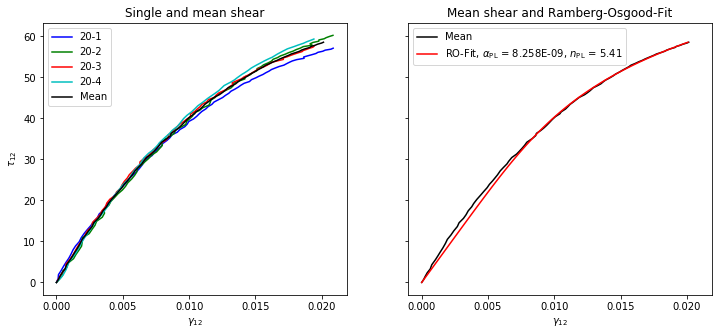

In [751]:
fig, cvs = plt.subplots(1, 2, sharex = True, sharey = True, figsize = (12,5))
c1 = cvs[0]
c2 = cvs[1]
colors = ['-b', '-g', '-r', '-c', '-m']
c1.set_title("Single and mean shear")
c2.set_title("Mean shear and Ramberg-Osgood-Fit")
c1.set_xlabel("$\\gamma_{12}$")
c1.set_ylabel("$\\tau_{12}$")
c2.set_xlabel("$\\gamma_{12}$")

# Left diagram:  Single and mean shear curves
# Right diagram: Mean curve and Ramberg-Osgood-Fit

for i in range(len(lengths)):
    c1.plot(strains[i], stresses[i], colors[i], label = "20-" + str(i+1))
c1.plot(strainsmean, stressesmean, '-k', label = "Mean")
c1.legend()

# For Ramberg-Osgood, we need to make a function.
def ro20(y, a, n):
    # measured shear modulus
    g12 = 4436.89625250778
    return (y + a*np.sign(y)*(np.abs(y))**n)/g12

# Create Curve Fit
popt, pcov = curve_fit(ro20, stressesmean, strainsmean, maxfev=1000000)

c2.plot(strainsmean, stressesmean, 'k', label = "Mean")
c2.plot(ro20(stressesmean, *popt), stressesmean, '-r', label = "RO-Fit, $\\alpha_{\mathrm{PL}}$ = %.3E, $n_{\mathrm{PL}}$ = %3.2f" %tuple(popt))
c2.legend()
plt

plt.show()

# Creating temperature dependent equation of RO Parameters

That was step 1. Step 2 will be to find temperature dependent equations for these parameters. For that, I'll write down the values into a dataframe without demonstration of calculation.

In [754]:
temperature = np.array([20., 40., 60., 80., 100.])
roa = np.array([8.257971E-09, 3.961905E-09, 2.403543E-11, 1.523679E-14, 2.992936E-14])
ron = np.array([5.41, 5.70, 7.17, 9.24, 9.29])

In [766]:
df = pd.DataFrame({'$\\alpha_{\mathrm{PL}}$': [8.257971E-09, 3.961905E-09, 2.403543E-11, 1.523679E-14, 2.992936E-14],
                   '$n_{\mathrm{PL}}$':        [5.41, 5.70, 7.17, 9.24, 9.29]},
                  index = [20, 40, 60, 80, 100])
df

,$\alpha_{\mathrm{PL}}$,$n_{\mathrm{PL}}$
20,8.257971e-09,5.41
40,3.961905e-09,5.70
60,2.403543e-11,7.17
80,1.523679e-14,9.24
100,2.992936e-14,9.29


Let's look how that looks in diagrams.

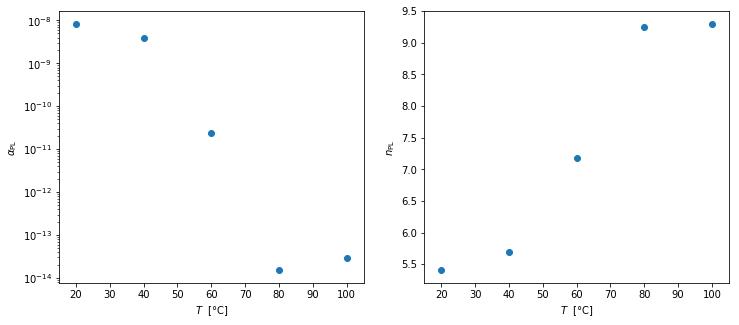

In [782]:
fig, ax = plt.subplots(1, 2, sharex = True, figsize=(12,5))
ax1=ax[0]
ax2=ax[1]

ax1.set_xlabel('$T$  $[\mathrm{°C}]$')
ax2.set_xlabel('$T$  $[\mathrm{°C}]$')

ax1.set_ylabel('$\\alpha_\mathrm{PL}$')
ax2.set_ylabel('$n_\mathrm{PL}$')

ax1.set_yscale('log')

ax1.scatter(temperature, roa)
ax2.scatter(temperature, ron)

plt.show()

As we can see, both plots represent s-curves. One first try was to do a fit in Excel via exponential functions.

In [786]:
def expa(x, a, b):
    return a * np.exp(b*x)

a1 = 9.99753125525157e-7
b1 = -0.187621108502736

a2 = 4.48565210999464
b2 = 0.00782273153739

x1 = np.linspace(20, 100, 1000)
y1 = expa(x1, a1, b1)
y2 = expa(x1, a2, b2)

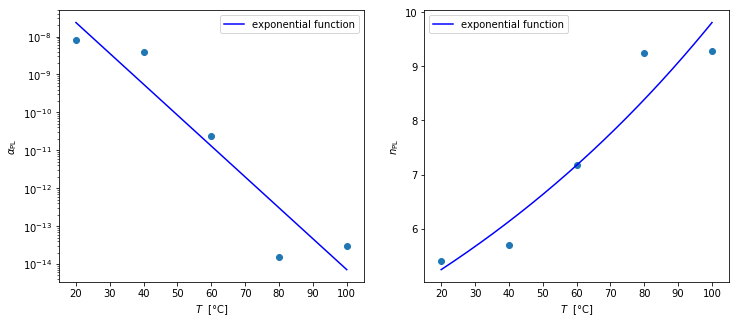

In [787]:
fig, ax = plt.subplots(1, 2, sharex = True, figsize=(12,5))
ax1=ax[0]
ax2=ax[1]

ax1.set_xlabel('$T$  $[\mathrm{°C}]$')
ax2.set_xlabel('$T$  $[\mathrm{°C}]$')

ax1.set_ylabel('$\\alpha_\mathrm{PL}$')
ax2.set_ylabel('$n_\mathrm{PL}$')

ax1.set_yscale('log')

ax1.scatter(temperature, roa)
ax2.scatter(temperature, ron)

ax1.plot(x1, y1, '-b', label='exponential function')
ax2.plot(x1, y2, '-b', label='exponential function')

ax1.legend()
ax2.legend()
plt.show()

That is ok, but there is a formular that represents an s-curve:

\begin{align}
y=\arctan(x)
\end{align}

In [796]:
def eatan(x, a, b, c, d, e):
    return a*np.exp(b*np.arctan(c*x+d)+e)

def atan(x, a, b, c, d):
    return a*np.arctan(b*x+c)+d

popta, pcova = curve_fit(eatan, temperature, roa, maxfev=1000000)
poptn, pcovn = curve_fit(atan, temperature, ron, maxfev=1000000)

y1a = eatan(x1, *popta)
y1n = atan(x1, *poptn)

/usr/lib/python3/dist-packages/scipy/optimize/minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


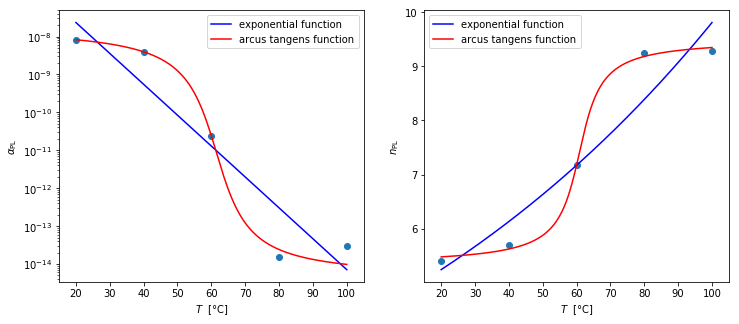

In [798]:
fig, ax = plt.subplots(1, 2, sharex = True, figsize=(12,5))
ax1=ax[0]
ax2=ax[1]

ax1.set_xlabel('$T$  $[\mathrm{°C}]$')
ax2.set_xlabel('$T$  $[\mathrm{°C}]$')

ax1.set_ylabel('$\\alpha_\mathrm{PL}$')
ax2.set_ylabel('$n_\mathrm{PL}$')

ax1.set_yscale('log')

ax1.scatter(temperature, roa)
ax2.scatter(temperature, ron)

ax1.plot(x1, y1, '-b', label='exponential function')
ax1.plot(x1, y1a, '-r', label = 'arcus tangens function')

ax2.plot(x1, y2, '-b', label='exponential function')
ax2.plot(x1, y1n, '-r', label= 'arcus tangens function')

ax1.legend()
ax2.legend()
plt.show()

# Done

We have created math equations for the Ramberg Osgood equations which we can use for further calculation and simulation.